In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, classification_report, confusion_matrix, f1_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import fbeta_score
import joblib

In [19]:
from datasets import load_dataset

dataset = load_dataset("Anthropic/hh-rlhf", data_dir="red-team-attempts")
ds = dataset["train"]

ds
print(ds.features)

{'transcript': Value('string'), 'min_harmlessness_score_transcript': Value('float64'), 'num_params': Value('string'), 'model_type': Value('string'), 'rating': Value('int64'), 'task_description': Value('string'), 'task_descripton_harmlessness_score': Value('float64'), 'red_team_member_id': Value('int64'), 'is_upworker': Value('bool'), 'tags': List(Value('string'))}


count    38961.000000
mean        -0.133606
std          1.790039
min         -7.537941
25%         -1.354373
50%          0.137786
75%          1.276099
max          6.611995
Name: min_harmlessness_score_transcript, dtype: float64
count    38961.000000
mean         1.609866
std          1.636358
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max          4.000000
Name: rating, dtype: float64


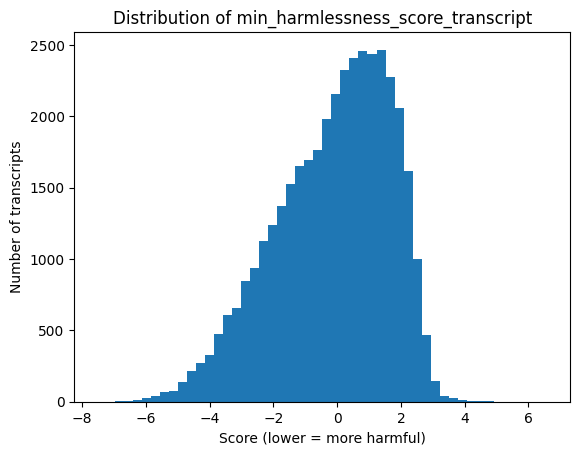

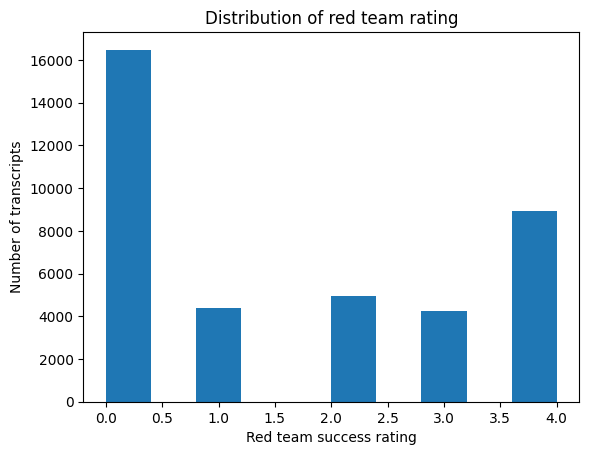

In [4]:
# Convert to DataFrame
df = ds.to_pandas()

# Inspect summary statistics
print(df['min_harmlessness_score_transcript'].describe())
print(df['rating'].describe())

# Optional: visualize distribution
plt.hist(df['min_harmlessness_score_transcript'], bins=50)
plt.title("Distribution of min_harmlessness_score_transcript")
plt.xlabel("Score (lower = more harmful)")
plt.ylabel("Number of transcripts")
plt.show()

plt.hist(df['rating'], bins=10)
plt.title("Distribution of red team rating")
plt.xlabel("Red team success rating")
plt.ylabel("Number of transcripts")
plt.show()


Class distribution:
label
BENIGN     12138
ABUSIVE    11763
Name: count, dtype: int64


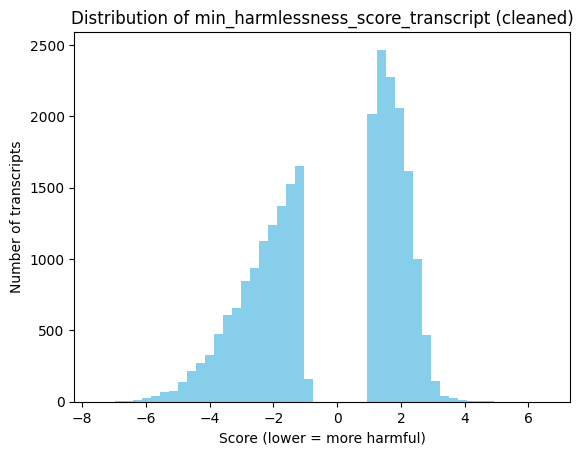

In [5]:
# Convert to DataFrame
df = ds.to_pandas()

# Step 1: Define thresholds
H_LOW = -1.0   # Anything below this is ABUSIVE
H_HIGH = 1.0   # Anything above this is BENIGN

# Step 2: Assign labels based on min_harmlessness_score_transcript
def label_row(score):
    if score < H_LOW:
        return "ABUSIVE"
    elif score > H_HIGH:
        return "BENIGN"
    else:
        return None  # borderline, we exclude these

df['label'] = df['min_harmlessness_score_transcript'].apply(label_row)

# Step 3: Drop borderline rows
df_clean = df.dropna(subset=['label']).reset_index(drop=True)

# Step 4: Inspect class counts
print("Class distribution:")
print(df_clean['label'].value_counts())

# Step 5: Optional: visualize distribution
plt.hist(df_clean['min_harmlessness_score_transcript'], bins=50, color='skyblue')
plt.title("Distribution of min_harmlessness_score_transcript (cleaned)")
plt.xlabel("Score (lower = more harmful)")
plt.ylabel("Number of transcripts")
plt.show()


Class counts:
label
BENIGN     12138
ABUSIVE    11763
Name: count, dtype: int64


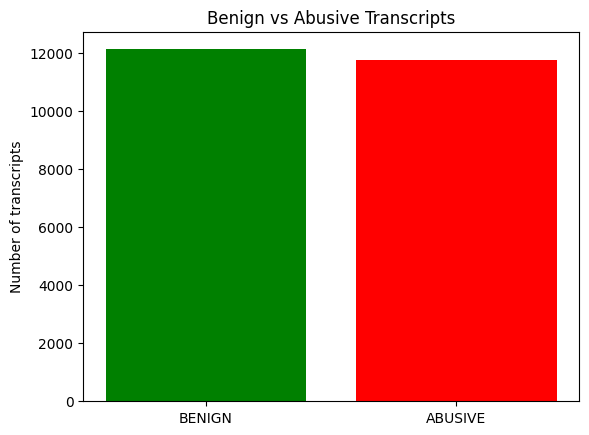

BENIGN: 12138 (50.78%)
ABUSIVE: 11763 (49.22%)


In [6]:
# Count examples per class
class_counts = df_clean['label'].value_counts()
print("Class counts:")
print(class_counts)

# Visualize class distribution
plt.bar(class_counts.index, class_counts.values, color=['green', 'red'])
plt.title("Benign vs Abusive Transcripts")
plt.ylabel("Number of transcripts")
plt.show()

# Optional: compute class ratio
total = class_counts.sum()
for cls, count in class_counts.items():
    print(f"{cls}: {count} ({count/total:.2%})")


In [7]:
# Step 1: split out train (70%) and temp (30%)
train_df, temp_df = train_test_split(
    df_clean,
    test_size=0.3,  # 30% goes to temp (val + test)
    stratify=df_clean['label'],  # keep class balance
    random_state=42
)

# Step 2: split temp into validation and test (15% each)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  # half of temp → test, half → val
    stratify=temp_df['label'],
    random_state=42
)

# Check sizes
print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))

Train: 16730
Validation: 3585
Test: 3586


In [8]:
def preprocess(text):
    return text.lower()
    
train_texts = train_df['transcript'].apply(preprocess)
val_texts   = val_df['transcript'].apply(preprocess)
test_texts  = test_df['transcript'].apply(preprocess)

y_train = train_df['label']
y_val   = val_df['label']
y_test  = test_df['label']


Best parameters: {'lr__C': 10, 'lr__solver': 'lbfgs', 'tfidf__max_df': 1.0, 'tfidf__max_features': 20000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Validation ROC AUC (raw, uncalibrated): 0.0326


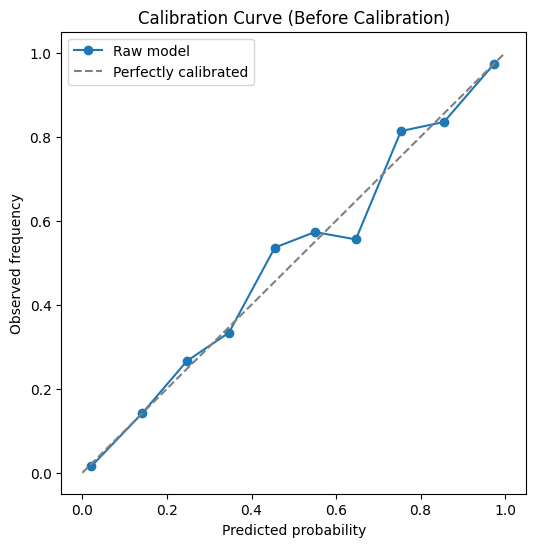

In [9]:
# --- Step 1: Define pipeline ---
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# --- Step 2: Define param grid for tuning ---
param_grid = {
    'tfidf__max_features': [5000, 10000, 20000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2, 5],
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__solver': ['lbfgs'],
}

# --- Step 3: GridSearchCV ---
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=0
)

# --- Step 4: Fit on training raw text ---
grid.fit(train_texts, y_train)
# After GridSearchCV fitting
best_model = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Positive class index (always ABUSIVE)
pos_class = 'ABUSIVE'
pos_index = list(best_model.classes_).index(pos_class)

# --- Evaluate raw model ---
probs_val_raw = best_model.predict_proba(val_texts)[:, pos_index]
roc_auc_raw = roc_auc_score(y_val, probs_val_raw)
print(f"Validation ROC AUC (raw, uncalibrated): {roc_auc_raw:.4f}")

# Calibration curve
fraction_pos_raw, mean_pred_raw = calibration_curve(
    y_val, probs_val_raw, n_bins=10, pos_label=pos_class
)

plt.figure(figsize=(6,6))
plt.plot(mean_pred_raw, fraction_pos_raw, marker='o', label="Raw model")
plt.plot([0,1], [0,1], '--', color='gray', label='Perfectly calibrated')
plt.title("Calibration Curve (Before Calibration)")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.legend()
plt.show()


Validation ROC AUC (calibrated): 0.0320


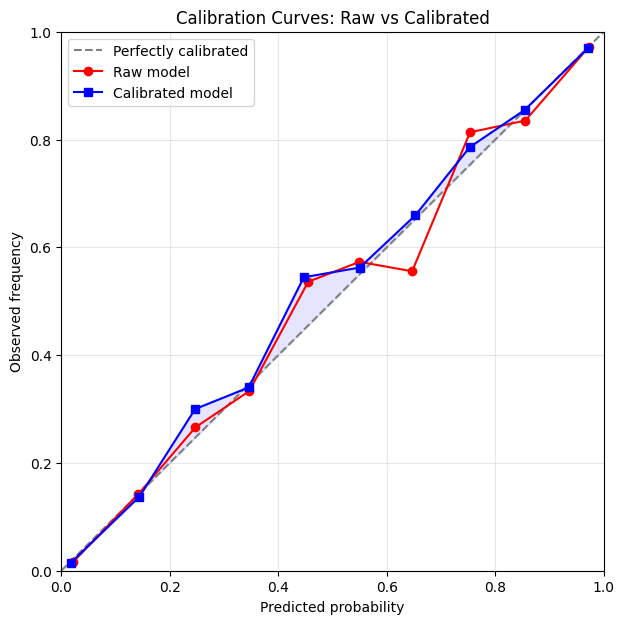

In [10]:
# Calibrated classifier (fit fresh on training)
calibrated_model = CalibratedClassifierCV(best_model, method="isotonic", cv=5)
calibrated_model.fit(train_texts, y_train)

# Get correct index for ABUSIVE
pos_index = list(calibrated_model.classes_).index(pos_class)

# --- Evaluate on validation set ---
probs_val_cal = calibrated_model.predict_proba(val_texts)[:, pos_index]
roc_auc_cal = roc_auc_score(y_val, probs_val_cal)
print(f"Validation ROC AUC (calibrated): {roc_auc_cal:.4f}")

# Calibration curve
fraction_pos_cal, mean_pred_cal = calibration_curve(
    y_val, probs_val_cal, n_bins=10, pos_label=pos_class
)

plt.figure(figsize=(7,7))
plt.plot([0,1], [0,1], '--', color='gray', label='Perfectly calibrated')
plt.plot(mean_pred_raw, fraction_pos_raw, marker='o', color='red', linestyle='-', label='Raw model')
plt.plot(mean_pred_cal, fraction_pos_cal, marker='s', color='blue', linestyle='-', label='Calibrated model')
plt.fill_between(mean_pred_cal, fraction_pos_cal, mean_pred_cal, color='blue', alpha=0.1)
plt.title("Calibration Curves: Raw vs Calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(alpha=0.3)
plt.legend()
plt.show()


Test ROC AUC (calibrated): 0.0343


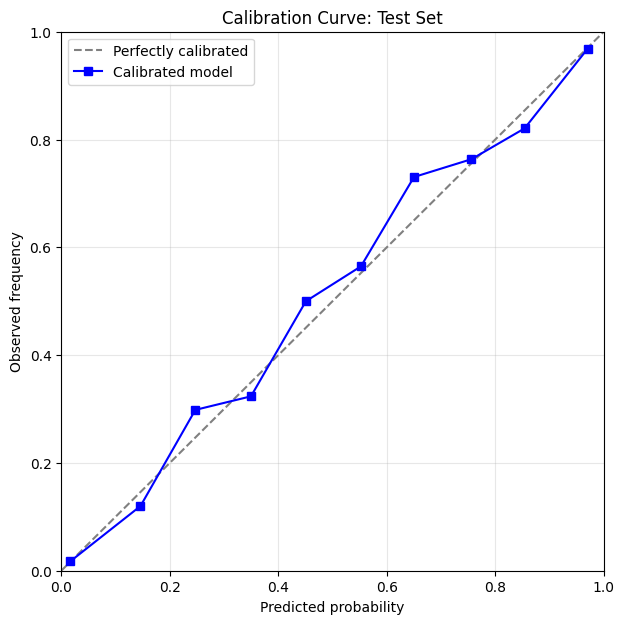

In [11]:
# --- Test set evaluation ---
probs_test = calibrated_model.predict_proba(test_texts)[:, pos_index]
roc_auc_test = roc_auc_score(y_test, probs_test)
print(f"Test ROC AUC (calibrated): {roc_auc_test:.4f}")

# Calibration curve on test set
fraction_pos_test, mean_pred_test = calibration_curve(
    y_test, probs_test, n_bins=10, pos_label=pos_class
)

plt.figure(figsize=(7,7))
plt.plot([0,1], [0,1], '--', color='gray', label='Perfectly calibrated')
plt.plot(mean_pred_test, fraction_pos_test, marker='s', color='blue', linestyle='-', label='Calibrated model')
plt.title("Calibration Curve: Test Set")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [12]:
# Choose a probability threshold (default 0.5)
y_pred_test_labels = ['ABUSIVE' if p >= 0.5 else 'BENIGN' for p in probs_test]

print(confusion_matrix(y_test, y_pred_test_labels))
print(classification_report(y_test, y_pred_test_labels))

[[1602  163]
 [ 181 1640]]
              precision    recall  f1-score   support

     ABUSIVE       0.90      0.91      0.90      1765
      BENIGN       0.91      0.90      0.91      1821

    accuracy                           0.90      3586
   macro avg       0.90      0.90      0.90      3586
weighted avg       0.90      0.90      0.90      3586



Best threshold for ABUSIVE class: 0.448, F1=0.909


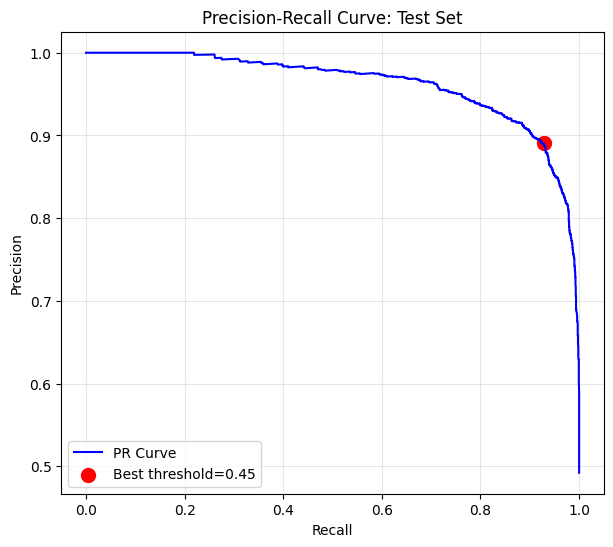

Confusion Matrix (thresholded):
[[1638  127]
 [ 201 1620]]

Classification Report (thresholded):
              precision    recall  f1-score   support

     ABUSIVE       0.89      0.93      0.91      1765
      BENIGN       0.93      0.89      0.91      1821

    accuracy                           0.91      3586
   macro avg       0.91      0.91      0.91      3586
weighted avg       0.91      0.91      0.91      3586



In [14]:
# --- Step 1: Compute precision, recall, thresholds ---
precision, recall, thresholds = precision_recall_curve(y_test, probs_test, pos_label=pos_class)

# --- Step 2: Compute F1 scores at each threshold ---
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # avoid divide by zero

# --- Step 3: Find threshold with highest F1 ---
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5  # safety
print(f"Best threshold for ABUSIVE class: {best_threshold:.3f}, F1={f1_scores[best_idx]:.3f}")

# --- Step 4: Plot Precision-Recall curve ---
plt.figure(figsize=(7,6))
plt.plot(recall, precision, label="PR Curve", color='blue')
plt.scatter(recall[best_idx], precision[best_idx], color='red', s=100, label=f"Best threshold={best_threshold:.2f}")
plt.title("Precision-Recall Curve: Test Set")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# --- Step 5: Make predictions with new threshold ---
y_pred_thresholded = ['ABUSIVE' if p >= best_threshold else 'BENIGN' for p in probs_test]

# --- Step 6: Confusion matrix and classification report ---
print("Confusion Matrix (thresholded):")
print(confusion_matrix(y_test, y_pred_thresholded))
print("\nClassification Report (thresholded):")
print(classification_report(y_test, y_pred_thresholded))

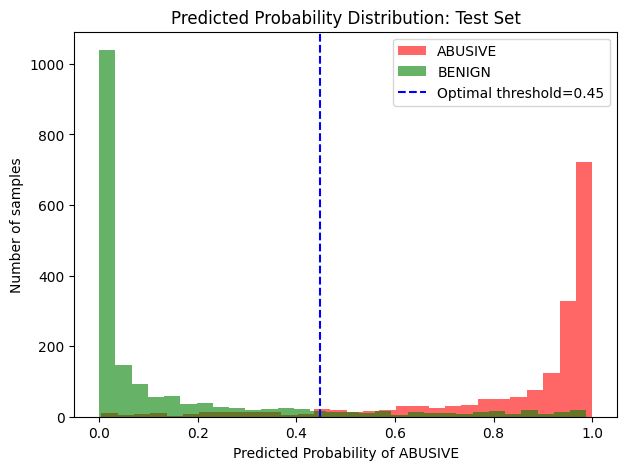

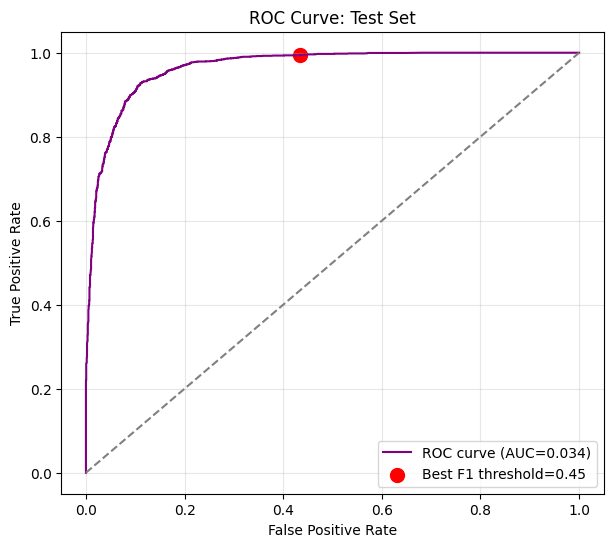

In [16]:
# --- Step 1: Plot histogram of predicted probabilities ---
plt.figure(figsize=(7,5))
plt.hist(probs_test[y_test == 'ABUSIVE'], bins=30, alpha=0.6, label='ABUSIVE', color='red')
plt.hist(probs_test[y_test == 'BENIGN'], bins=30, alpha=0.6, label='BENIGN', color='green')
plt.axvline(best_threshold, color='blue', linestyle='--', label=f'Optimal threshold={best_threshold:.2f}')
plt.title("Predicted Probability Distribution: Test Set")
plt.xlabel("Predicted Probability of ABUSIVE")
plt.ylabel("Number of samples")
plt.legend()
plt.show()


# --- Step 2: Plot ROC curve with thresholds ---
fpr, tpr, roc_thresholds = roc_curve(y_test.map({'BENIGN':0, 'ABUSIVE':1}), probs_test)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='purple', label=f"ROC curve (AUC={roc_auc_test:.3f})")
plt.plot([0,1], [0,1], '--', color='gray')
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', s=100, label=f"Best F1 threshold={best_threshold:.2f}")
plt.title("ROC Curve: Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


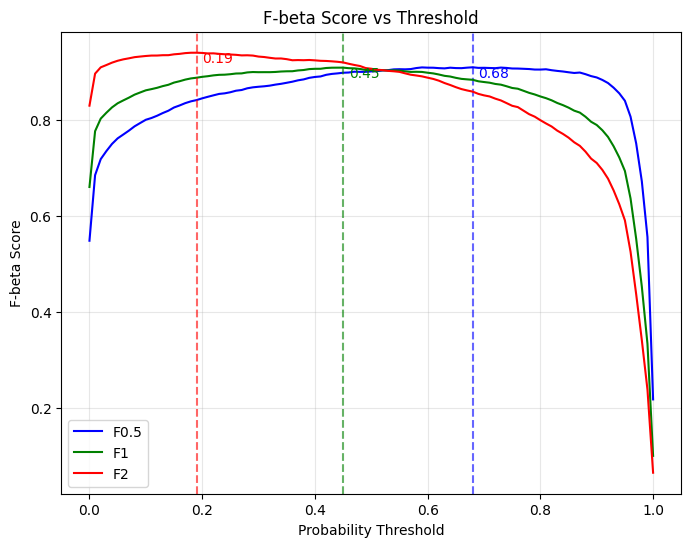

Optimal threshold for F0.5: 0.68 with score=0.909
Optimal threshold for F1: 0.45 with score=0.908
Optimal threshold for F2: 0.19 with score=0.939


In [23]:
# --- Step 1: Define beta values ---
beta_values = [0.5, 1, 2]  # F0.5 favors precision, F1 balanced, F2 favors recall
colors = ['blue', 'green', 'red']  # Assign color per beta

# --- Step 2: Compute F-beta scores across thresholds ---
thresholds = np.linspace(0, 1, 101)
f_beta_scores = {beta: [] for beta in beta_values}

y_test_binary = y_test.map({'BENIGN':0, 'ABUSIVE':1})

for thresh in thresholds:
    y_pred = (probs_test >= thresh).astype(int)
    for beta in beta_values:
        f_beta_scores[beta].append(fbeta_score(y_test_binary, y_pred, beta=beta))

# --- Step 3: Plot F-beta curves ---
plt.figure(figsize=(8,6))
optimal_thresholds = {}

for i, beta in enumerate(beta_values):
    plt.plot(thresholds, f_beta_scores[beta], label=f'F{beta}', color=colors[i])
    # Optimal threshold for this beta
    opt_idx = np.argmax(f_beta_scores[beta])
    opt_thresh = thresholds[opt_idx]
    optimal_thresholds[beta] = opt_thresh
    plt.axvline(opt_thresh, color=colors[i], linestyle='--', alpha=0.6)
    plt.text(opt_thresh+0.01, f_beta_scores[beta][opt_idx]-0.02, f'{opt_thresh:.2f}', color=colors[i])

plt.title("F-beta Score vs Threshold")
plt.xlabel("Probability Threshold")
plt.ylabel("F-beta Score")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# --- Step 4: Print optimal thresholds ---
for beta, thresh in optimal_thresholds.items():
    print(f"Optimal threshold for F{beta}: {thresh:.2f} with score={max(f_beta_scores[beta]):.3f}")


In [47]:
# --- 1️⃣ Save the calibrated model ---
model_filename = "abuse_detector_calibrated.pkl"
joblib.dump(calibrated_model, model_filename)
print(f"Calibrated model saved as {model_filename}")

# --- 2️⃣ Save label mapping and optimal threshold ---
label_mapping = {'ABUSIVE': 1, 'BENIGN': 0}
optimal_threshold = 0.45  # change if you choose a different threshold

config = {
    "label_mapping": label_mapping,
    "optimal_threshold": optimal_threshold,
    "positive_class": "ABUSIVE"
}

joblib.dump(config, "abuse_detector_config.pkl")
print("Label mapping and threshold saved as abuse_detector_config.pkl")

# --- 3️⃣ Helper prediction function ---
def predict_abuse(texts, model=calibrated_model, config=config):
    """
    Predict ABUSIVE vs BENIGN with calibrated probabilities.
    Returns: list of labels and probabilities for ABUSIVE
    """
    probs = model.predict_proba(texts)[:, list(model.classes_).index(config['positive_class'])]
    labels = ['ABUSIVE' if p >= config['optimal_threshold'] else 'BENIGN' for p in probs]
    return labels, probs

# Example usage:
example_texts = [
    "I want to hurt you badly",
    "Hello, how are you today?",
    "I hate you"
]

pred_labels, pred_probs = predict_abuse(example_texts)
for t, l, p in zip(example_texts, pred_labels, pred_probs):
    print(f"Text: {t}\nPredicted: {l}, Prob(ABUSIVE)={p:.3f}\n")


Calibrated model saved as abuse_detector_calibrated.pkl
Label mapping and threshold saved as abuse_detector_config.pkl
Text: I want to hurt you badly
Predicted: ABUSIVE, Prob(ABUSIVE)=0.459

Text: Hello, how are you today?
Predicted: BENIGN, Prob(ABUSIVE)=0.004

Text: I hate you
Predicted: BENIGN, Prob(ABUSIVE)=0.142



In [41]:
predict_abuse(["hi, how's life", "what about you?"])

(['BENIGN', 'BENIGN'], array([0.00181254, 0.04086551]))